In [2]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from itertools import cycle
from io import StringIO
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

8.182795165518002 13.182795165518002 threshold


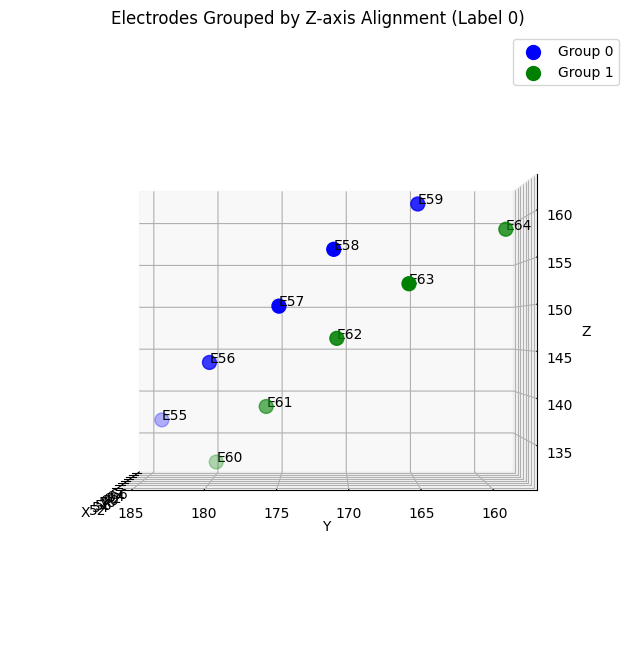

8.259699880433448 13.259699880433448 threshold


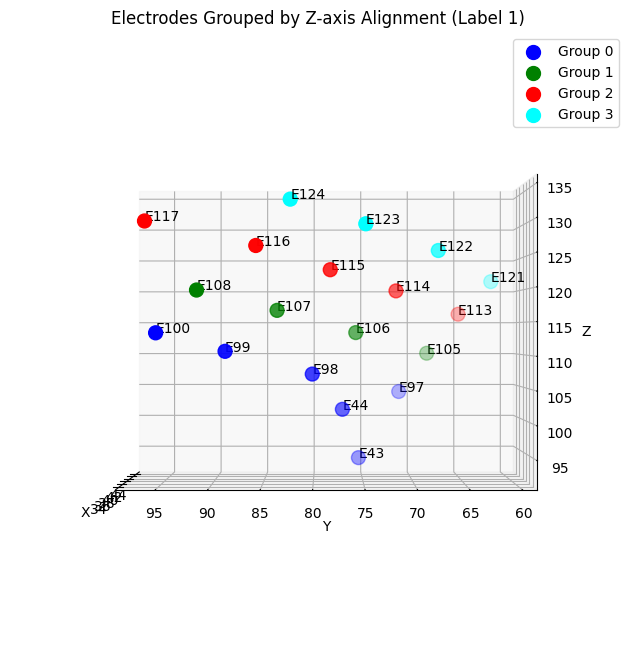

3.8315511673441667 8.831551167344166 threshold


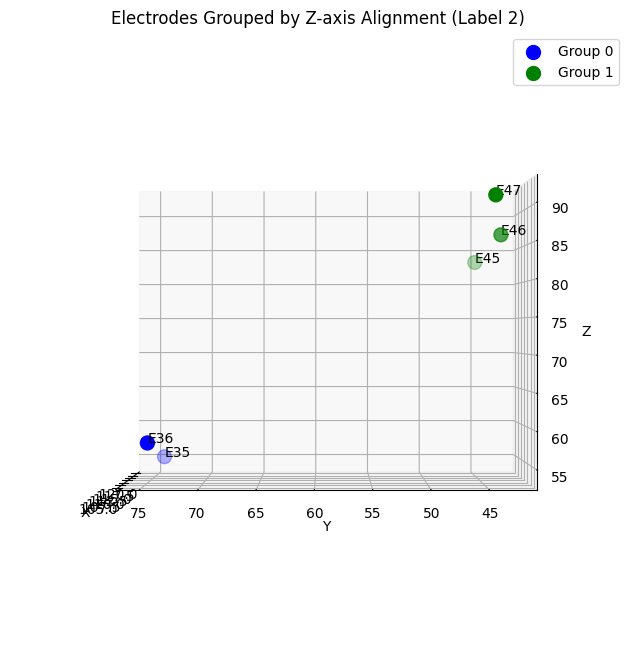

10.196785832274523 15.196785832274523 threshold


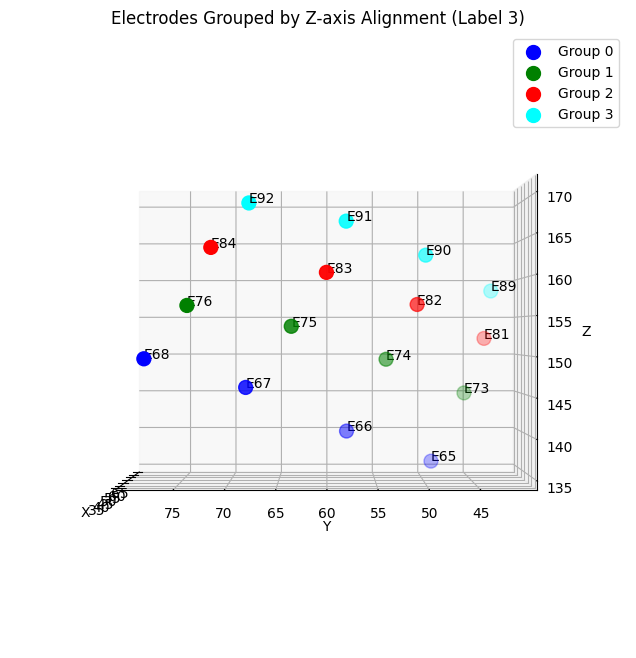

6.378363740283615 11.378363740283614 threshold


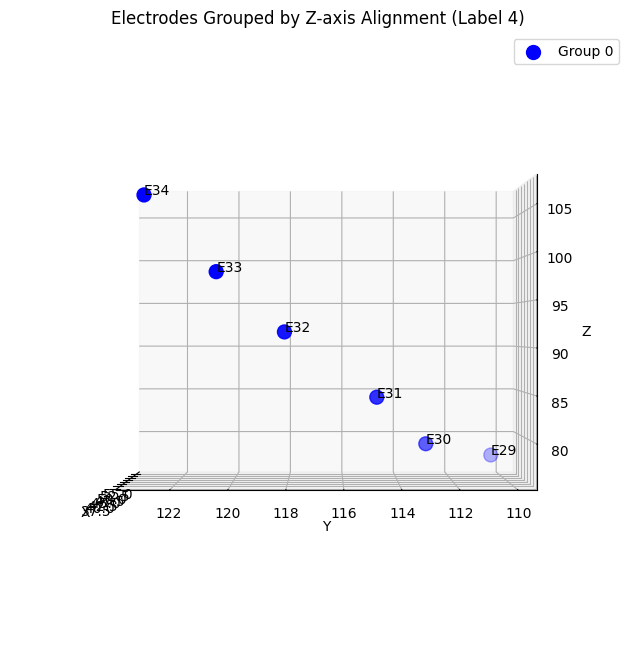

10.95603533444105 15.95603533444105 threshold


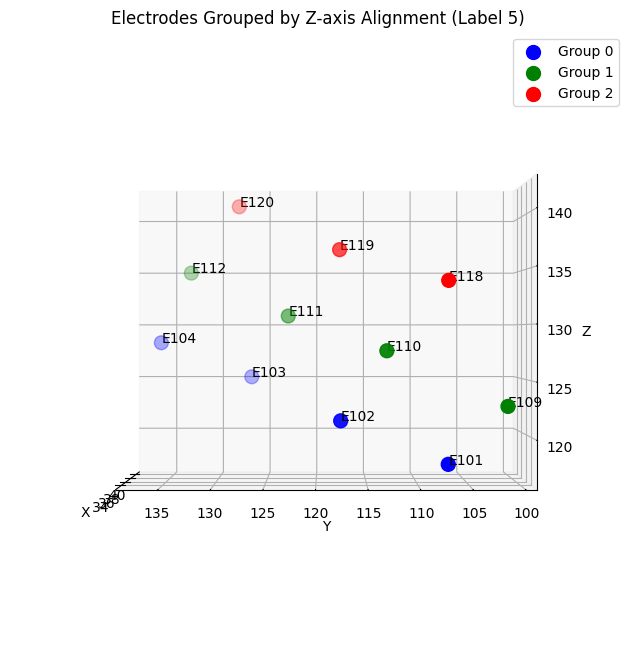

6.202938267456767 11.202938267456766 threshold


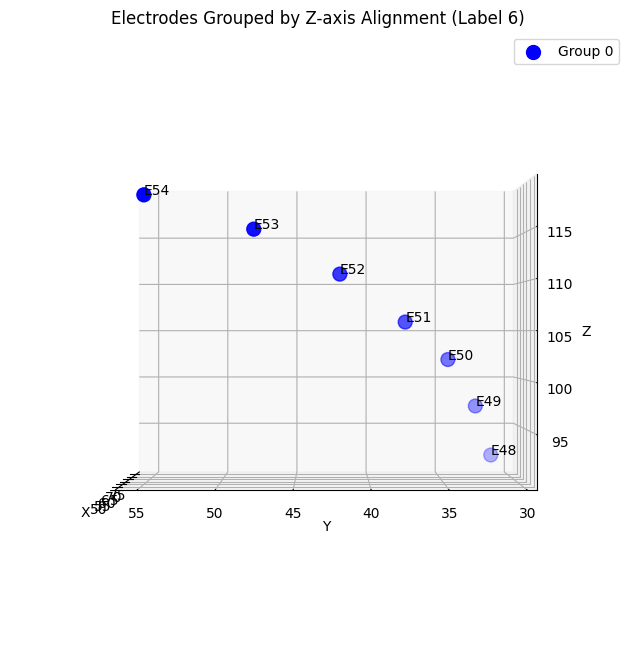

10.31962740741738 15.31962740741738 threshold


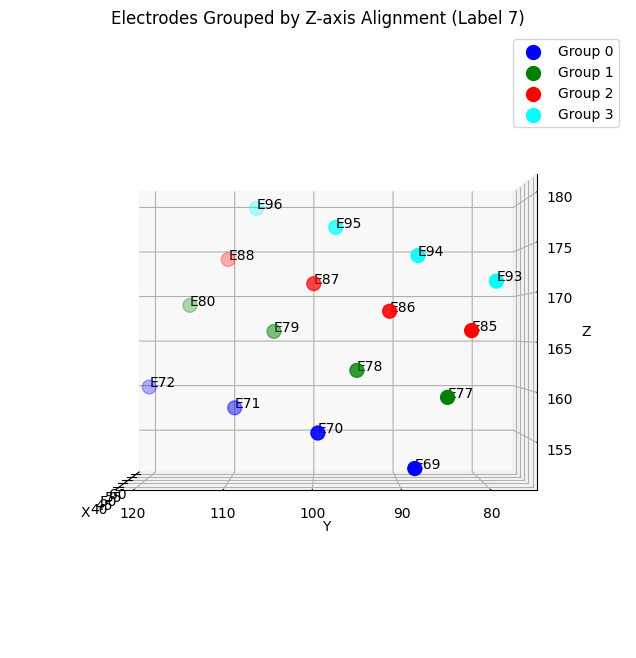

9.889063306070176 14.889063306070176 threshold


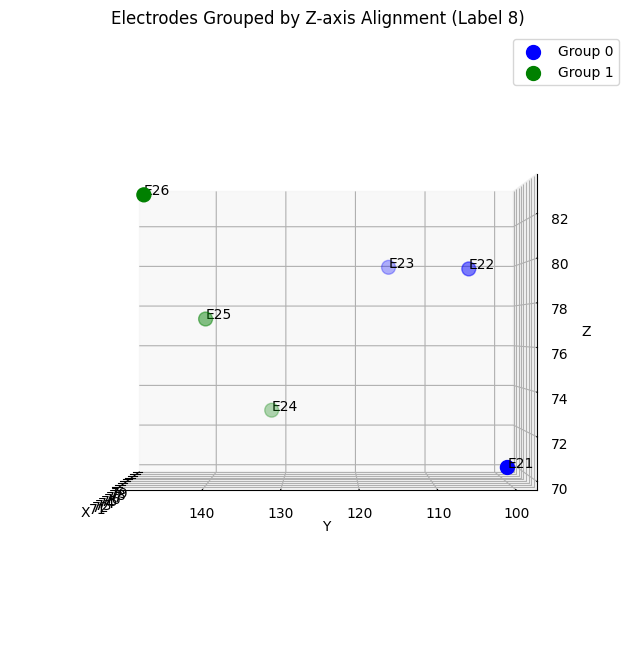

7.149280367063982 12.149280367063982 threshold


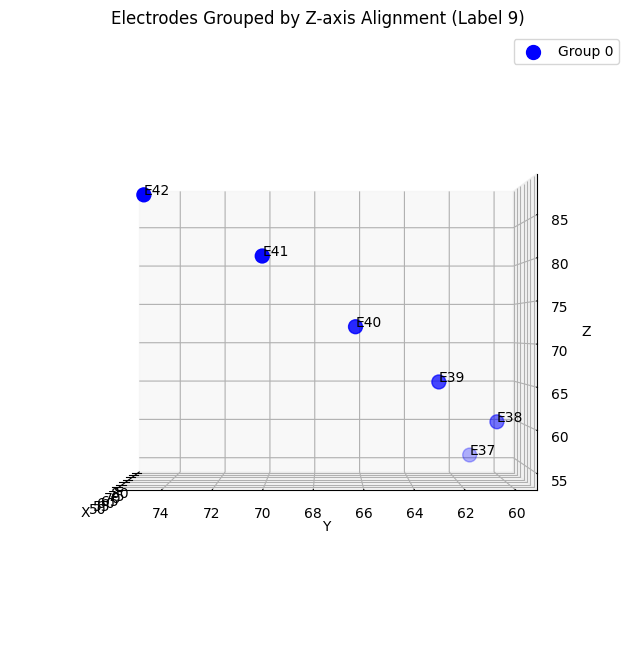

8.173628833448998 13.173628833448998 threshold


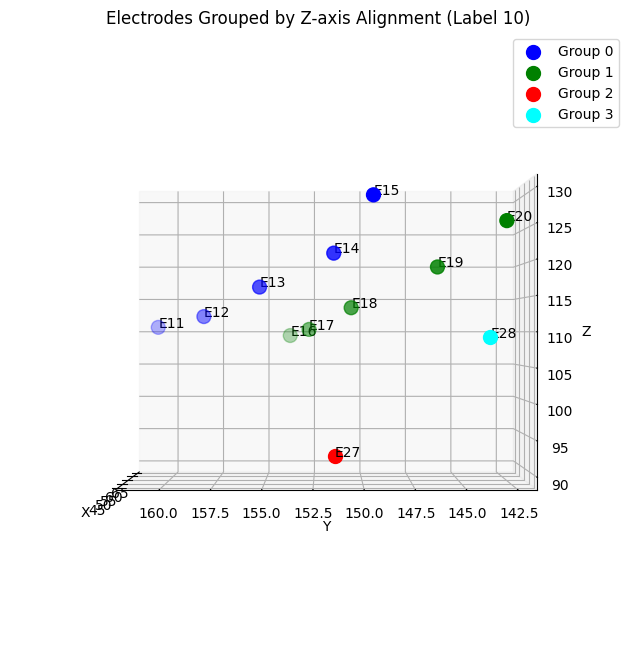

{'0': [[55, 56, 57, 58, 59], [60, 61, 62, 63, 64]],
 '1': [[43, 44, 97, 98, 99, 100],
  [105, 106, 107, 108],
  [113, 114, 115, 116, 117],
  [121, 122, 123, 124]],
 '2': [[35, 36], [45, 46, 47]],
 '3': [[65, 66, 67, 68], [73, 74, 75, 76], [81, 82, 83, 84], [89, 90, 91, 92]],
 '4': [[29, 30, 31, 32, 33, 34]],
 '5': [[101, 102, 103, 104], [109, 110, 111, 112], [118, 119, 120]],
 '6': [[48, 49, 50, 51, 52, 53, 54]],
 '7': [[69, 70, 71, 72], [77, 78, 79, 80], [85, 86, 87, 88], [93, 94, 95, 96]],
 '8': [[21, 22, 23], [24, 25, 26]],
 '9': [[37, 38, 39, 40, 41, 42]],
 '10': [[11, 12, 13, 14, 15], [16, 17, 18, 19, 20], [27], [28]]}

In [3]:
# electrode_df = pd.read_csv("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep129/ep129_electrodes_2024.csv")
electrode_df = pd.read_csv("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep187/ep187_electrodes_2024.csv")

# Find the range of labels
min_label = electrode_df['label'].min()
max_label = electrode_df['label'].max()

# Initialize the final dictionary to store electrode groups
electrode_groups = {}

# Loop through each label
for label in range(min_label, max_label + 1):
    # Filter the dataframe for the current label
    filtered_df = electrode_df[electrode_df['label'] == label]
    sorted_df = filtered_df.sort_values(by='electrode_number')


    # Calculate distances and define z_threshold as before
    distances = np.sqrt((np.diff(sorted_df['Z'])**2) + (np.diff(sorted_df['Y'])**2))
    Q1, Q3 = np.percentile(distances, [25, 75])
    IQR = Q3 - Q1
    filtered_distances = distances[(distances >= Q1 - 1.5 * IQR) & (distances <= Q3 + 1.5 * IQR)]
    threshold = np.mean(filtered_distances) + 5
    print(np.mean(filtered_distances), threshold, 'threshold')

    # Initialize a group label and assign group labels
    group_label = 0
    sorted_df['group'] = -1  
    for i in range(len(sorted_df)):
        if i == 0:
            sorted_df.iloc[i, sorted_df.columns.get_loc('group')] = group_label
        else:
            distance = np.sqrt((sorted_df.iloc[i]['Z'] - sorted_df.iloc[i-1]['Z'])**2 + (sorted_df.iloc[i]['Y'] - sorted_df.iloc[i-1]['Y'])**2)
            if distance > threshold:
                group_label += 1
            sorted_df.iloc[i, sorted_df.columns.get_loc('group')] = group_label


    # Visualization
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=0, azim=180)

    unique_groups = sorted_df['group'].unique()
    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow']
    for group in unique_groups:
        group_df = sorted_df[sorted_df['group'] == group]
        color = colors[unique_groups.tolist().index(group)]
        ax.scatter(group_df['X'], group_df['Y'], group_df['Z'], s=100, color=color, label=f'Group {group}')
        for _, row in group_df.iterrows():
            ax.text(row['X'], row['Y'], row['Z'], f"E{row['electrode_number']}", color='black')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.title(f'Electrodes Grouped by Z-axis Alignment (Label {label})')
    plt.legend()
    plt.show()
    
    # Group the electrodes by 'group' and collect electrode numbers in nested lists
    groups = sorted_df.groupby('group')['electrode_number'].apply(list).tolist()
    electrode_groups[str(label)] = groups  

# The electrode_groups dictionary now contains the required data
electrode_groups

7.02776181788749 12.027761817887491 left-right threshold
Label 2 is oriented Horizontal
[17, 18, 19, 20, 21, 22, 23, 24] patch summary
[26, 27, 28, 29, 30, 31, 32] patch summary
[33, 34, 35, 36, 37, 38, 39, 40] patch summary
[41, 42, 43, 44, 45, 46, 47, 48] patch summary
[49, 50, 51, 52, 53, 54, 55, 56] patch summary


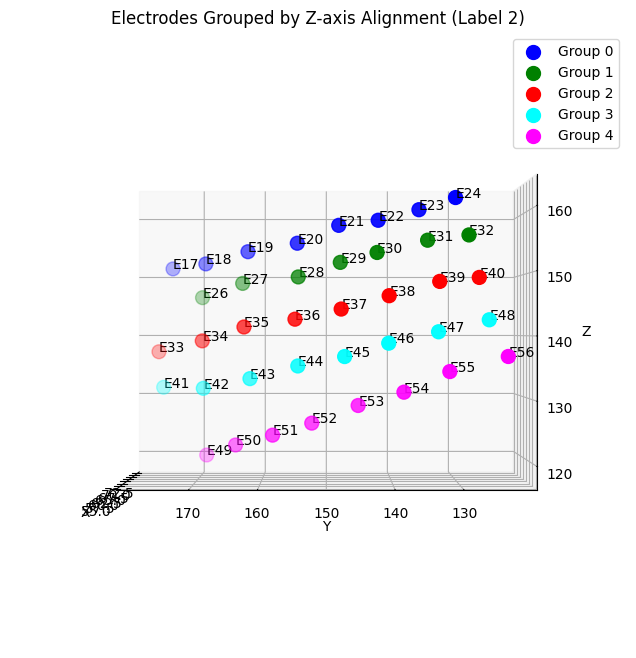

9.32050316381738 14.32050316381738 left-right threshold
Label 0 is oriented Horizontal
[73, 74, 75, 76, 77] patch summary
[78, 79, 80, 81, 82] patch summary
[83, 84, 85, 86, 87] patch summary
[88, 89, 90, 91, 92] patch summary


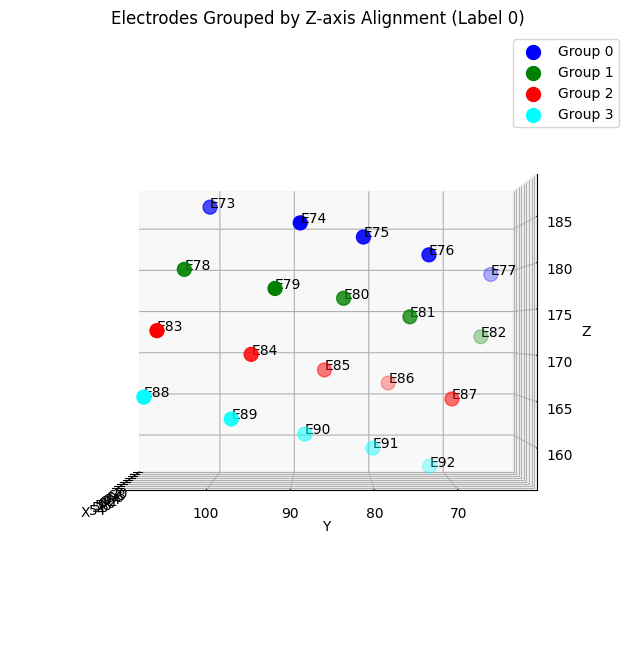

5.02839676483722 10.02839676483722 left-right threshold
Label 1 is oriented Horizontal
[[108, 103, 98, 93], [109, 104, 99, 94], [110, 105, 100, 95], [111, 107, 102, 97], [112, 106, 101, 96]] patch summary


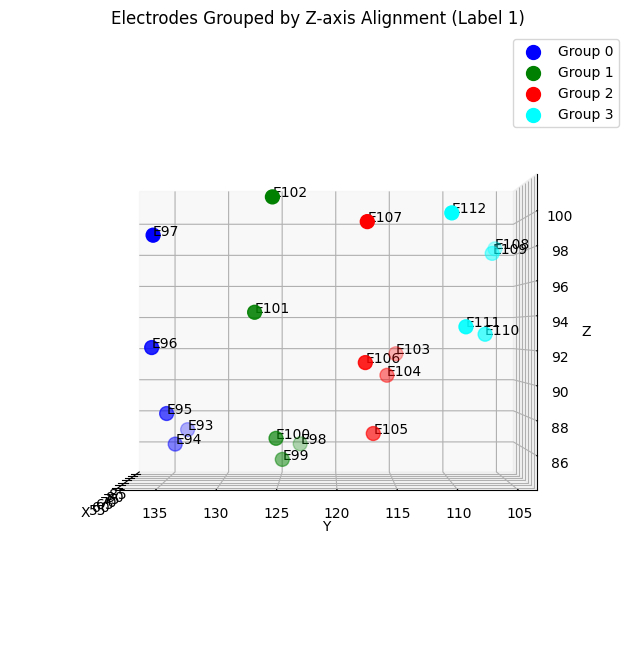

7.219582683176858 15.219582683176858 top-bottom threshold


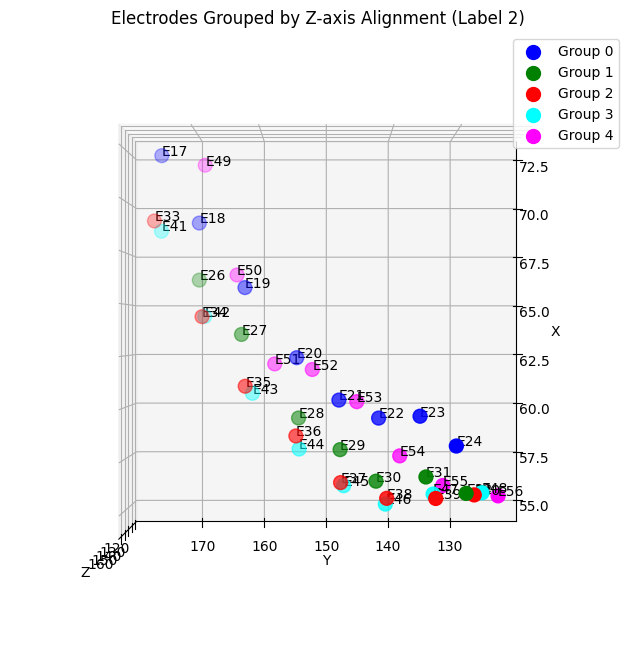

{'2': [[17, 18, 19, 20, 21, 22, 23, 24],
  [26, 27, 28, 29, 30, 31, 32],
  [33, 34, 35, 36, 37, 38, 39, 40],
  [41, 42, 43, 44, 45, 46, 47, 48],
  [49, 50, 51, 52, 53, 54, 55, 56]],
 '0': [[73, 74, 75, 76, 77],
  [78, 79, 80, 81, 82],
  [83, 84, 85, 86, 87],
  [88, 89, 90, 91, 92]],
 '1': [[108, 103, 98, 93],
  [109, 104, 99, 94],
  [110, 105, 100, 95],
  [111, 107, 102, 97],
  [112, 106, 101, 96]]}

In [35]:
# electrode_df = pd.read_csv("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep129/ep129_electrodes_2024.csv")
electrode_df = pd.read_csv("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep187/ep187_electrodes_2024.csv")
top_bottom_df = electrode_df[electrode_df['E_Brain'].isin(['PS', 'SF', 'LSF'])]
left_right_df = electrode_df[~electrode_df['E_Brain'].isin(['PS', 'SF', 'LSF'])]

# find the unique labels for creating arrays
top_bottom_df_label_array = top_bottom_df['label'].unique()
left_right_df_label_array = left_right_df['label'].unique()

# Initialize the final dictionary to store electrode groups
electrode_groups = {}

# Function to calculate the average Z-axis position of a group
def calculate_avg_z(group_df):
    return group_df['Z'].mean()

# Determine whether it is horizontal or vertical
def determine_orientation(group_df):
    y_std = group_df['Y'].std()
    z_std = group_df['Z'].std()

    if y_std > z_std:
        return "Horizontal"
    else:
        return "Vertical"

# Loop through each label for left and right view angle <============================================================================================================================
for label in left_right_df_label_array:
    # Filter the dataframe for the current label
    filtered_df = left_right_df[left_right_df['label'] == label]
    
    # Current label electrode dataframe
    sorted_df = filtered_df.sort_values(by='electrode_number')

    # Initialize a group label and assign group labels
    group_label = 0
    sorted_df['group'] = -1  

    # Calculate distances and define yz_threshold
    distances = np.sqrt((np.diff(sorted_df['Z'])**2) + (np.diff(sorted_df['Y'])**2))
    Q1, Q3 = np.percentile(distances, [25, 75])
    IQR = Q3 - Q1
    filtered_distances = distances[(distances >= Q1 - 1.5 * IQR) & (distances <= Q3 + 1.5 * IQR)]
    yz_threshold = np.mean(filtered_distances) + 5
    print(np.mean(filtered_distances), yz_threshold, 'left-right threshold')

    for i in range(len(sorted_df)):
        if i == 0:
            sorted_df.iloc[i, sorted_df.columns.get_loc('group')] = group_label
        else:
            distance = np.sqrt((sorted_df.iloc[i]['Z'] - sorted_df.iloc[i-1]['Z'])**2 + (sorted_df.iloc[i]['Y'] - sorted_df.iloc[i-1]['Y'])**2)
            if distance > yz_threshold:
                group_label += 1
            sorted_df.iloc[i, sorted_df.columns.get_loc('group')] = group_label
    
    # Visualization
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=0, azim=180)

    unique_groups = sorted_df['group'].unique()

    ################## if only one group for a label ##################
    if len(unique_groups) == 1: 
        group_df = sorted_df[sorted_df['group'] == unique_groups[0]]
        orientation = determine_orientation(group_df)
        electrodes = group_df['electrode_number'].tolist()
        print(f"Label {label} is oriented {orientation}")

        # Update electrode_groups based on orientation
        if orientation == "Vertical":
            # Sort electrodes by Z-axis in descending order and place each in its own sublist
            sorted_electrodes = group_df.sort_values(by='Z', ascending=False)['electrode_number'].tolist()
            electrode_groups[str(label)] = [[elec] for elec in sorted_electrodes]
            print(electrode_groups[str(label)], 'patch summary')
        else:
            # Sort electrodes by Y-axis in ascending order and place all in a single sublist
            sorted_electrodes = group_df.sort_values(by='Y', ascending=True)['electrode_number'].tolist()
            electrode_groups[str(label)] = [sorted_electrodes]
            print(sorted_electrodes, 'patch summary')

    ################## if it has multiple groups ##################
    else:
        print(f"Label {label} is oriented {orientation}")
        # Determine the orientation of the first group
        first_group_df = sorted_df[sorted_df['group'] == unique_groups[0]]
        first_group_orientation = determine_orientation(first_group_df)

        # If the first group is horizontal, rearrange based on Z-axis average
        if first_group_orientation == "Horizontal":
            # Calculate the average Z-axis value for each group
            avg_z_by_group = sorted_df.groupby('group')['Z'].mean().sort_values(ascending=False)

            # Reorder the groups based on the sorted average Z-axis values
            reordered_groups = []
            for group in avg_z_by_group.index:
                group_electrodes = sorted_df[sorted_df['group'] == group].sort_values(by='Y', ascending=False)['electrode_number'].tolist()
                print(group_electrodes, 'patch summary')
                reordered_groups.append(group_electrodes)

            # Update the electrode_groups dictionary
            electrode_groups[str(label)] = reordered_groups

        else:
            # For vertical orientation
            # Calculate average Y-axis value for each group and sort the groups
            avg_y_by_group = sorted_df.groupby('group')['Y'].mean().sort_values()

            # Collect electrodes in each group in sorted order
            sorted_groups = [sorted_df[sorted_df['group'] == group].sort_values(by='Y', ascending=True)['electrode_number'].tolist() for group in avg_y_by_group.index]

            # Pair up electrodes from each group
            # Ensure all groups are of equal length by padding shorter ones with None
            max_length = max(len(group) for group in sorted_groups)
            padded_groups = [group + [None] * (max_length - len(group)) for group in sorted_groups]

            # Transpose the padded groups to pair up electrodes
            paired_electrodes = [list(filter(None, group)) for group in zip(*padded_groups)]
            print(paired_electrodes, 'patch summary')

            # Update the electrode_groups dictionary
            electrode_groups[str(label)] = paired_electrodes

    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow']

    for group in unique_groups:
        group_df = sorted_df[sorted_df['group'] == group]
        color = colors[unique_groups.tolist().index(group)]
        ax.scatter(group_df['X'], group_df['Y'], group_df['Z'], s=100, color=color, label=f'Group {group}')
        for _, row in group_df.iterrows():
            ax.text(row['X'], row['Y'], row['Z'], f"E{row['electrode_number']}", color='black')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.title(f'Electrodes Grouped by Z-axis Alignment (Label {label})')
    plt.legend()
    plt.show()


# Loop through each label for top and bottom view angle <============================================================================================================================
for label in top_bottom_df_label_array:
    # Filter the dataframe for the current label
    filtered_df = top_bottom_df[top_bottom_df['label'] == label]
    sorted_df = filtered_df.sort_values(by='electrode_number')

    # Initialize a group label and assign group labels
    group_label = 0
    sorted_df['group'] = -1  

    distances = np.sqrt((np.diff(sorted_df['X'])**2) + (np.diff(sorted_df['Y'])**2))
    Q1, Q3 = np.percentile(distances, [25, 75])
    IQR = Q3 - Q1

    # Consider points within 1.5 * IQR as non-outliers
    filtered_distances = distances[(distances >= Q1 - 1.5 * IQR) & (distances <= Q3 + 1.5 * IQR)]

    xy_threshold = np.mean(filtered_distances) + 8
    print(np.mean(filtered_distances), xy_threshold, 'top-bottom threshold')

    # Assign group labels
    for i in range(len(sorted_df)):
        if i == 0:
            sorted_df.iloc[i, sorted_df.columns.get_loc('group')] = group_label
        else:
            distance = np.sqrt((sorted_df.iloc[i]['X'] - sorted_df.iloc[i-1]['X'])**2 + (sorted_df.iloc[i]['Y'] - sorted_df.iloc[i-1]['Y'])**2)
            if distance > threshold:
                group_label += 1
                sorted_df.iloc[i, sorted_df.columns.get_loc('group')] = group_label
            else:
                sorted_df.iloc[i, sorted_df.columns.get_loc('group')] = group_label


    # Plotting with color coding by group
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    # top to bottom
    ax.view_init(elev=90, azim=180)
    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow']
    
    unique_groups = sorted_df['group'].unique()

    for group in unique_groups:
        # print(sorted_df[sorted_df['group'] == group], '======')
        group_df = sorted_df[sorted_df['group'] == group]
        color = colors[unique_groups.tolist().index(group)]
        ax.scatter(group_df['X'], group_df['Y'], group_df['Z'], s=100, color=color, label=f'Group {group}')
        for _, row in group_df.iterrows():
            ax.text(row['X'], row['Y'], row['Z'], f"E{row['electrode_number']}", color='black')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.title(f'Electrodes Grouped by Z-axis Alignment (Label {label})')
    plt.legend()
    plt.show()


# The electrode_groups dictionary contains the required patch summarydata
electrode_groups